In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,close_raw,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.301415e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.405474e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.517855e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.639221e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.815000,6.849078e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.675000,6.122057e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.670000,6.104678e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.240000,4.770902e-01


In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_sel,
    look_back      = params.look_back_tick,
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    num_workers    = params.hparams["NUM_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = params.return_threshold_tick
)

for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

--- TRAIN ---
 calendar days : 3840  (2004-01-02 → 2019-04-04)
 windows       : 1731840  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches= 60, batch_size=64, workers=12, pin_memory=True

--- VAL ---
 calendar days : 751  (2019-04-05 → 2022-03-28)
 windows       : 338701  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches=751, batch_size=1, workers=0, pin_memory=True

--- TEST ---
 calendar days : 809  (2022-03-29 → 2025-06-18)
 windows       : 364859  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches=809, batch_size=1, workers=0, pin_memory=True



In [5]:
# importlib.reload(params.model_selected) #############

# -----------------------------------------------------------------------------
# Instantiate the ModelClass & move to device
# -----------------------------------------------------------------------------

model = params.model_selected.ModelClass(
    n_feats          = len(params.features_cols_tick),                          
    short_units      = params.hparams['SHORT_UNITS'],    
    long_units       = params.hparams['LONG_UNITS'],     
    dropout_short    = params.hparams['DROPOUT_SHORT'],  
    dropout_long     = params.hparams['DROPOUT_LONG'],   
    # att_heads        = params.hparams['ATT_HEADS'],
    # att_drop         = params.hparams['ATT_DROPOUT'],
    conv_k           = params.hparams['CONV_K'],
    conv_dilation    = params.hparams['CONV_DILATION'],
    # smooth_k         = params.hparams['SMOOTH_K'],
    # smooth_dilation  = params.hparams['SMOOTH_DILATION']
    pred_hidden      = params.hparams['PRED_HIDDEN'],
)
model.to(params.device)  

model

ModelClass(
  (conv): Conv1d(17, 17, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (short_lstm): LSTM(17, 64, batch_first=True, bidirectional=True)
  (ln_short): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (do_short): Dropout(p=0.3, inplace=False)
  (short2long): Linear(in_features=128, out_features=256, bias=True)
  (ln_long): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (do_long): Dropout(p=0.3, inplace=False)
  (pred): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [6]:
# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models_core.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 5e-06
    lr: 5e-06
    maximize: False
    weight_decay: 0.0003
)

In [7]:
# -----------------------------------------------------------------------------
# Helper: extract the true “signal” values from any loader into a flat array
# -----------------------------------------------------------------------------
def extract_y(loader):
    return np.concatenate([batch[1].cpu().numpy().ravel() for batch in loader])

# Pull out train & validation targets
y_train = extract_y(train_loader)
y_val   = extract_y(val_loader)

# -----------------------------------------------------------------------------
# 1) Zero‐forecast baseline RMSE (predict 0 always)
#    RMSE_zero = √(mean(y²))
# -----------------------------------------------------------------------------
rmse_zero_train = np.sqrt(np.mean(y_train**2))
rmse_zero_val   = np.sqrt(np.mean(y_val**2))
print(f"Zero‐forecast RMSE (predict 0): train = {rmse_zero_train:.6f},  val = {rmse_zero_val:.6f}\n")

# -----------------------------------------------------------------------------
# 2) Compute mean, variance & std for train/validation targets
#    and derive the mean‐predictor baseline (R² = 0)
# -----------------------------------------------------------------------------
for split, y in [("Train", y_train), ("Validation", y_val)]:
    mean_y    = y.mean()
    std_y     = y.std(ddof=0)     # population std = √variance
    var_y     = std_y**2
    rmse_mean = std_y            # RMSE_baseline = std(target)

    print(f"{split} target stats:")
    print(f"  mean = {mean_y:.4f},  var = {var_y:.4f},  std = {std_y:.4f}")
    print(f"{split} mean‐predictor baseline:")
    print(f"  RMSE_baseline = {rmse_mean:.6f}")
    print("  R²_baseline   = 0.00\n")

    if split == "Validation":
        rmse_mean_val = rmse_mean # used afterwards for the final reporting
        


Zero‐forecast RMSE (predict 0): train = 0.405952,  val = 0.409382

Train target stats:
  mean = 0.2836,  var = 0.0844,  std = 0.2905
Train mean‐predictor baseline:
  RMSE_baseline = 0.290471
  R²_baseline   = 0.00

Validation target stats:
  mean = 0.2919,  var = 0.0824,  std = 0.2870
Validation mean‐predictor baseline:
  RMSE_baseline = 0.287012
  R²_baseline   = 0.00



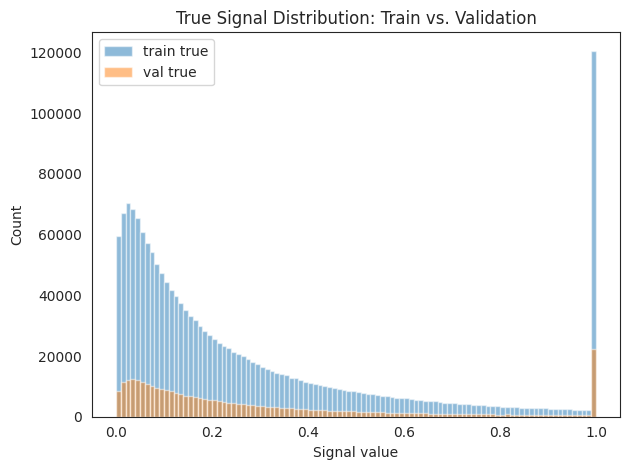

In [8]:
# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=100, alpha=0.5, label="train true")
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


Training sees 3840 unique trading days per epoch.

Using HyperParameters:
 "look_back": 60 {'CONV_K': 3, 'CONV_DILATION': 1, 'SHORT_UNITS': 128, 'DROPOUT_SHORT': 0.3, 'LONG_UNITS': 256, 'PRED_HIDDEN': 128, 'DROPOUT_LONG': 0.3, 'DIFF1_WEIGHT': 1.0, 'DIFF2_WEIGHT': 2.0, 'SMOOTH_ALPHA': 0.05, 'SMOOTH_BETA': 100.0, 'SMOOTH_DELTA': 0.02, 'LR_EPOCHS_WARMUP': 1, 'INITIAL_LR': 5e-06, 'WEIGHT_DECAY': 0.0003, 'CLIPNORM': 1.0, 'ETA_MIN': 1e-07, 'T_0': 100, 'T_MULT': 1, 'TRAIN_BATCH': 64, 'VAL_BATCH': 1, 'NUM_WORKERS': 12, 'TRAIN_PREFETCH_FACTOR': 4, 'MAX_EPOCHS': 100, 'EARLY_STOP_PATIENCE': 7, 'PLATEAU_FACTOR': 0.9, 'PLATEAU_PATIENCE': 0, 'MIN_LR': 1e-06, 'PLAT_EPOCHS_WARMUP': 999}


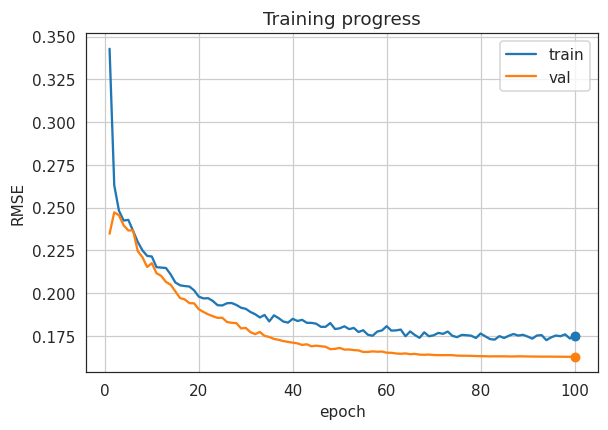

Epoch 1 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 01  TRAIN RMSE=0.3429  VALID RMSE=0.2347


Epoch 2 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 2 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 02  TRAIN RMSE=0.2630  VALID RMSE=0.2472


Epoch 3 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 3 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 03  TRAIN RMSE=0.2482  VALID RMSE=0.2455


Epoch 4 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 4 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 04  TRAIN RMSE=0.2424  VALID RMSE=0.2396


Epoch 5 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 5 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 05  TRAIN RMSE=0.2428  VALID RMSE=0.2366


Epoch 6 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 6 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 06  TRAIN RMSE=0.2364  VALID RMSE=0.2367


Epoch 7 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 7 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 07  TRAIN RMSE=0.2299  VALID RMSE=0.2245


Epoch 8 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 8 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 08  TRAIN RMSE=0.2250  VALID RMSE=0.2210


Epoch 9 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 9 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 09  TRAIN RMSE=0.2218  VALID RMSE=0.2153


Epoch 10 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 10 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 10  TRAIN RMSE=0.2214  VALID RMSE=0.2175


Epoch 11 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 11 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 11  TRAIN RMSE=0.2151  VALID RMSE=0.2116


Epoch 12 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 12 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 12  TRAIN RMSE=0.2149  VALID RMSE=0.2100


Epoch 13 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 13 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 13  TRAIN RMSE=0.2147  VALID RMSE=0.2065


Epoch 14 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 14 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 14  TRAIN RMSE=0.2110  VALID RMSE=0.2049


Epoch 15 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 15 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 15  TRAIN RMSE=0.2062  VALID RMSE=0.2010


Epoch 16 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 16 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 16  TRAIN RMSE=0.2046  VALID RMSE=0.1971


Epoch 17 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 17 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 17  TRAIN RMSE=0.2041  VALID RMSE=0.1963


Epoch 18 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 18 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 18  TRAIN RMSE=0.2038  VALID RMSE=0.1941


Epoch 19 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 19 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 19  TRAIN RMSE=0.2016  VALID RMSE=0.1940


Epoch 20 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 20 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 20  TRAIN RMSE=0.1979  VALID RMSE=0.1905


Epoch 21 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 21 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 21  TRAIN RMSE=0.1969  VALID RMSE=0.1889


Epoch 22 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 22 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 22  TRAIN RMSE=0.1970  VALID RMSE=0.1876


Epoch 23 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 23 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 23  TRAIN RMSE=0.1954  VALID RMSE=0.1865


Epoch 24 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 24 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 24  TRAIN RMSE=0.1929  VALID RMSE=0.1855


Epoch 25 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 25 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 25  TRAIN RMSE=0.1927  VALID RMSE=0.1855


Epoch 26 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 26 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 26  TRAIN RMSE=0.1941  VALID RMSE=0.1831


Epoch 27 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 27 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 27  TRAIN RMSE=0.1942  VALID RMSE=0.1826


Epoch 28 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 28 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 28  TRAIN RMSE=0.1930  VALID RMSE=0.1824


Epoch 29 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 29 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 29  TRAIN RMSE=0.1914  VALID RMSE=0.1793


Epoch 30 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 30 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 30  TRAIN RMSE=0.1908  VALID RMSE=0.1796


Epoch 31 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 31 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 31  TRAIN RMSE=0.1889  VALID RMSE=0.1771


Epoch 32 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 32 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 32  TRAIN RMSE=0.1876  VALID RMSE=0.1760


Epoch 33 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 33 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 33  TRAIN RMSE=0.1857  VALID RMSE=0.1773


Epoch 34 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 34 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 34  TRAIN RMSE=0.1872  VALID RMSE=0.1750


Epoch 35 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 35 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 35  TRAIN RMSE=0.1834  VALID RMSE=0.1743


Epoch 36 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 36 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 36  TRAIN RMSE=0.1870  VALID RMSE=0.1732


Epoch 37 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 37 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 37  TRAIN RMSE=0.1853  VALID RMSE=0.1726


Epoch 38 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 38 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 38  TRAIN RMSE=0.1833  VALID RMSE=0.1719


Epoch 39 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 39 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 39  TRAIN RMSE=0.1827  VALID RMSE=0.1714


Epoch 40 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 40 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 40  TRAIN RMSE=0.1849  VALID RMSE=0.1710


Epoch 41 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 41 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 41  TRAIN RMSE=0.1837  VALID RMSE=0.1706


Epoch 42 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 42 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 42  TRAIN RMSE=0.1843  VALID RMSE=0.1697


Epoch 43 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 43 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 43  TRAIN RMSE=0.1826  VALID RMSE=0.1700


Epoch 44 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 44 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 44  TRAIN RMSE=0.1826  VALID RMSE=0.1689


Epoch 45 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 45 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 45  TRAIN RMSE=0.1821  VALID RMSE=0.1692


Epoch 46 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 46 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 46  TRAIN RMSE=0.1802  VALID RMSE=0.1689


Epoch 47 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 47 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 47  TRAIN RMSE=0.1803  VALID RMSE=0.1686


Epoch 48 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 48 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 48  TRAIN RMSE=0.1825  VALID RMSE=0.1672


Epoch 49 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 49 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 49  TRAIN RMSE=0.1790  VALID RMSE=0.1674


Epoch 50 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 50 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 50  TRAIN RMSE=0.1794  VALID RMSE=0.1679


Epoch 51 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 51 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 51  TRAIN RMSE=0.1806  VALID RMSE=0.1669


Epoch 52 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 52 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 52  TRAIN RMSE=0.1789  VALID RMSE=0.1670


Epoch 53 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 53 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 53  TRAIN RMSE=0.1796  VALID RMSE=0.1667


Epoch 54 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 54 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 54  TRAIN RMSE=0.1772  VALID RMSE=0.1665


Epoch 55 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 55 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 55  TRAIN RMSE=0.1783  VALID RMSE=0.1656


Epoch 56 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 56 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 56  TRAIN RMSE=0.1756  VALID RMSE=0.1656


Epoch 57 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 57 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 57  TRAIN RMSE=0.1750  VALID RMSE=0.1659


Epoch 58 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 58 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 58  TRAIN RMSE=0.1775  VALID RMSE=0.1657


Epoch 59 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 59 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 59  TRAIN RMSE=0.1782  VALID RMSE=0.1658


Epoch 60 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 60 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 60  TRAIN RMSE=0.1806  VALID RMSE=0.1651


Epoch 61 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 61 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 61  TRAIN RMSE=0.1780  VALID RMSE=0.1651


Epoch 62 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 62 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 62  TRAIN RMSE=0.1782  VALID RMSE=0.1647


Epoch 63 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 63 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 63  TRAIN RMSE=0.1786  VALID RMSE=0.1645


Epoch 64 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 64 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 64  TRAIN RMSE=0.1748  VALID RMSE=0.1647


Epoch 65 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 65 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 65  TRAIN RMSE=0.1776  VALID RMSE=0.1642


Epoch 66 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 66 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 66  TRAIN RMSE=0.1755  VALID RMSE=0.1644


Epoch 67 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 67 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 67  TRAIN RMSE=0.1738  VALID RMSE=0.1640


Epoch 68 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 68 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 68  TRAIN RMSE=0.1770  VALID RMSE=0.1639


Epoch 69 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 69 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 69  TRAIN RMSE=0.1747  VALID RMSE=0.1640


Epoch 70 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 70 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 70  TRAIN RMSE=0.1753  VALID RMSE=0.1638


Epoch 71 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 71 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 71  TRAIN RMSE=0.1767  VALID RMSE=0.1637


Epoch 72 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 72 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 72  TRAIN RMSE=0.1762  VALID RMSE=0.1637


Epoch 73 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 73 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 73  TRAIN RMSE=0.1775  VALID RMSE=0.1637


Epoch 74 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 74 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 74  TRAIN RMSE=0.1750  VALID RMSE=0.1637


Epoch 75 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 75 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 75  TRAIN RMSE=0.1742  VALID RMSE=0.1634


Epoch 76 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 76 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 76  TRAIN RMSE=0.1756  VALID RMSE=0.1634


Epoch 77 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 77 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 77  TRAIN RMSE=0.1754  VALID RMSE=0.1633


Epoch 78 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 78 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 78  TRAIN RMSE=0.1751  VALID RMSE=0.1633


Epoch 79 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 79 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 79  TRAIN RMSE=0.1737  VALID RMSE=0.1632


Epoch 80 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 80 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 80  TRAIN RMSE=0.1763  VALID RMSE=0.1631


Epoch 81 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 81 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 81  TRAIN RMSE=0.1747  VALID RMSE=0.1631


Epoch 82 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 82 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 82  TRAIN RMSE=0.1731  VALID RMSE=0.1630


Epoch 83 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 83 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 83  TRAIN RMSE=0.1728  VALID RMSE=0.1630


Epoch 84 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 84 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 84  TRAIN RMSE=0.1748  VALID RMSE=0.1630


Epoch 85 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 85 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 85  TRAIN RMSE=0.1737  VALID RMSE=0.1630


Epoch 86 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 86 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 86  TRAIN RMSE=0.1750  VALID RMSE=0.1629


Epoch 87 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 87 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 87  TRAIN RMSE=0.1761  VALID RMSE=0.1629


Epoch 88 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 88 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 88  TRAIN RMSE=0.1752  VALID RMSE=0.1630


Epoch 89 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 89 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 89  TRAIN RMSE=0.1756  VALID RMSE=0.1630


Epoch 90 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 90 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 90  TRAIN RMSE=0.1746  VALID RMSE=0.1629


Epoch 91 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 91 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 91  TRAIN RMSE=0.1733  VALID RMSE=0.1629


Epoch 92 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 92 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 92  TRAIN RMSE=0.1752  VALID RMSE=0.1629


Epoch 93 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 93 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 93  TRAIN RMSE=0.1754  VALID RMSE=0.1628


Epoch 94 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 94 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 94  TRAIN RMSE=0.1725  VALID RMSE=0.1628


Epoch 95 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 95 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 95  TRAIN RMSE=0.1741  VALID RMSE=0.1628


Epoch 96 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 96 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 96  TRAIN RMSE=0.1752  VALID RMSE=0.1628


Epoch 97 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 97 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 97  TRAIN RMSE=0.1748  VALID RMSE=0.1628


Epoch 98 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 98 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 98  TRAIN RMSE=0.1758  VALID RMSE=0.1627


Epoch 99 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 99 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 99  TRAIN RMSE=0.1734  VALID RMSE=0.1627


Epoch 100 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 100 ▶ Valid:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 100  TRAIN RMSE=0.1749  VALID RMSE=0.1627
✅ Final‐best model saved: AAPL_0.16273_fin.pth


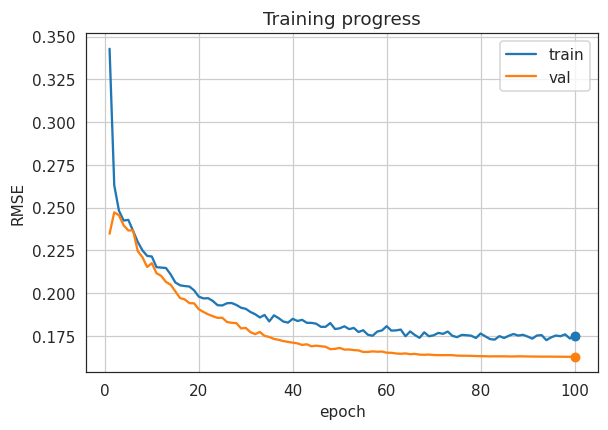

In [9]:
importlib.reload(params.model_selected) #############
importlib.reload(models_core) #############

# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

print('Using HyperParameters:\n "look_back":', params.look_back_tick, params.hparams)

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = params.model_selected.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = clipnorm,
    device              = params.device,
    # cls_loss_weight     = params.hparams['CLS_LOSS_WEIGHT'],
    # smooth_alpha        = params.hparams['SMOOTH_ALPHA'],
    # smooth_beta         = params.hparams['SMOOTH_BETA'],
    # smooth_delta        = params.hparams['SMOOTH_DELTA'],
    # diff1_weight        = params.hparams['DIFF1_WEIGHT'],
    # diff2_weight        = params.hparams['DIFF2_WEIGHT'],
)


In [10]:
# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement_zero = 100.0 * (1.0 - best_val_rmse / rmse_zero_val)
print(f"Improvement over zero‐baseline = {improvement_zero:5.1f}%")

improvement_mean = 100.0 * (1.0 - best_val_rmse / rmse_mean_val)
print(f"Improvement over mean‐baseline = {improvement_mean:5.1f}%")



Champion validation RMSE = 0.162734
Improvement over zero‐baseline =  60.2%
Improvement over mean‐baseline =  43.3%
